In [29]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

memory_data = torchvision.datasets.ImageFolder(root='eurosat_new/train', transform=test_transform)
memory_loader = DataLoader(memory_data, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
### raw data

raw_list = []
for i in range(len(memory_data)):
  raw_list.append(memory_data[i][0])
raw_data = np.stack(raw_list,axis=0).reshape(len(memory_data),-1)

df = pd.DataFrame(raw_data)
df['y'] = memory_data.targets

pca = PCA(n_components=50)
pca_result = pca.fit_transform(raw_data)

In [9]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, n_iter_without_progress=300, init='pca')
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24300 samples in 0.001s...
[t-SNE] Computed neighbors for 24300 samples in 6.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24300
[t-SNE] Computed conditional probabilities for sample 2000 / 24300
[t-SNE] Computed conditional probabilities for sample 3000 / 24300
[t-SNE] Computed conditional probabilities for sample 4000 / 24300
[t-SNE] Computed conditional probabilities for sample 5000 / 24300
[t-SNE] Computed conditional probabilities for sample 6000 / 24300
[t-SNE] Computed conditional probabilities for sample 7000 / 24300
[t-SNE] Computed conditional probabilities for sample 8000 / 24300
[t-SNE] Computed conditional probabilities for sample 9000 / 24300
[t-SNE] Computed conditional probabilities for sample 10000 / 24300
[t-SNE] Computed conditional probabilities for sample 11000 / 24300
[t-SNE] Computed conditional probabilities for sample 12000 / 24300
[t-SNE] Computed conditional probabilities for sa

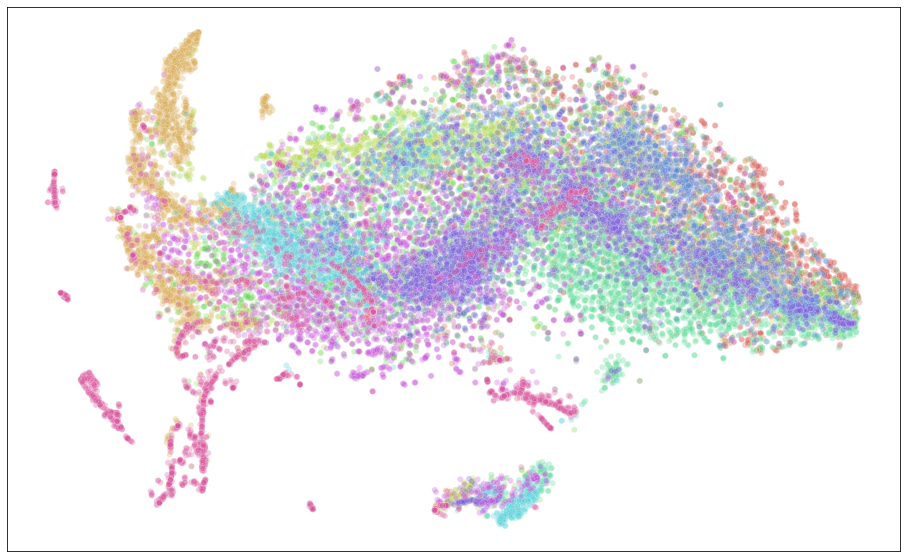

In [21]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 24})
tsne_plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend=None,
    alpha=0.3
)

tsne_plot.set(xticklabels=[])  # remove the tick labels
tsne_plot.set(yticklabels=[])  # remove the tick labels
tsne_plot.set(xlabel=None)  # remove the axis label
tsne_plot.set(ylabel=None)  # remove the axis label
tsne_plot.tick_params(bottom=False,left=False)
fig = tsne_plot.get_figure()

fig.savefig('tsne_raw.svg',transparent=True)

In [46]:
net = torchvision.models.resnet18(pretrained=False)
net.fc = torch.nn.Linear(512,128)
#net.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
# random

net.eval()
feature_bank = []
targets = []
with torch.no_grad():  
    for data, target in tqdm(memory_loader, desc='Feature extracting'):
        feature = net(data.cuda(non_blocking=True))
        feature = F.normalize(feature, dim=1)
        feature_bank.append(feature)
        targets.append(target)
    feature_data = torch.cat(feature_bank).cpu().reshape(len(memory_data),-1)
    target_data = memory_data.targets
    df = pd.DataFrame(feature_data)
    df['y'] = target_data
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(feature_data)

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, n_iter_without_progress=300)
    tsne_results = tsne.fit_transform(pca_result)
    tsne_time = time.time()-time_start
    print('t-SNE done! Time elapsed: {} seconds'.format(tsne_time))

Feature extracting: 100%|██████████| 95/95 [00:56<00:00,  1.67it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24300 samples in 0.001s...
[t-SNE] Computed neighbors for 24300 samples in 5.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24300
[t-SNE] Computed conditional probabilities for sample 2000 / 24300
[t-SNE] Computed conditional probabilities for sample 3000 / 24300
[t-SNE] Computed conditional probabilities for sample 4000 / 24300
[t-SNE] Computed conditional probabilities for sample 5000 / 24300
[t-SNE] Computed conditional probabilities for sample 6000 / 24300
[t-SNE] Computed conditional probabilities for sample 7000 / 24300
[t-SNE] Computed conditional probabilities for sample 8000 / 24300
[t-SNE] Computed conditional probabilities for sample 9000 / 24300
[t-SNE] Computed conditional probabilities for sample 10000 / 24300
[t-SNE] Computed conditional probabilities for sample 11000 / 24300
[t-SNE] Computed conditional probabilities for sample 12000 / 24300
[t-SNE] Computed conditional probabilities for sa

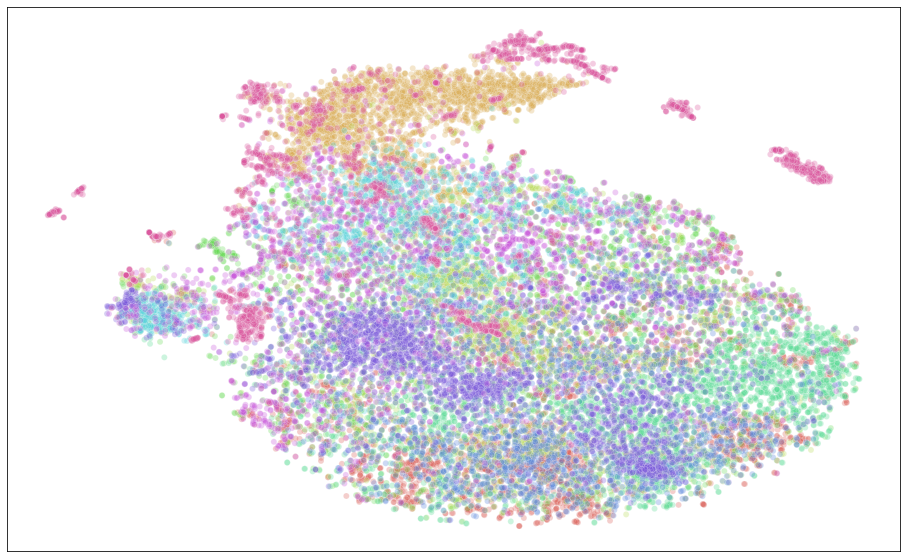

In [48]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
tsne_plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend=None,
    alpha=0.3
)

tsne_plot.set(xticklabels=[])  # remove the tick labels
tsne_plot.set(yticklabels=[])  # remove the tick labels
tsne_plot.set(xlabel=None)  # remove the axis label
tsne_plot.set(ylabel=None)  # remove the axis label
tsne_plot.tick_params(bottom=False,left=False)
fig = tsne_plot.get_figure()

fig.savefig('tsne_random.svg',transparent=True)

In [37]:
# load from pre-trained, before DistributedDataParallel constructor
pretrained_model = '/mnt/e/doctoral/weights/SSL4EO-S12/B3_moco_rn18_ep200_ckpt.pth.tar'
if os.path.isfile(pretrained_model):
    print("=> loading checkpoint '{}'".format(pretrained_model))
    checkpoint = torch.load(pretrained_model, map_location="cpu")

    # rename moco pre-trained keys
    state_dict = checkpoint['state_dict']
    
    for k in list(state_dict.keys()):
        # retain only encoder up to before the embedding layer
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            # remove prefix
            state_dict[k[len("module.encoder_q."):]] = state_dict[k]
        # delete renamed or unused k
        del state_dict[k]
    '''
    # remove prefix
    state_dict = {k.replace("module.", ""): v for k,v in state_dict.items()}
    '''
    msg = net.load_state_dict(state_dict, strict=False)
    assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}

    print("=> loaded pre-trained model '{}'".format(pretrained_model))
else:
    print("=> no checkpoint found at '{}'".format(pretrained_model))

=> loading checkpoint '/mnt/e/doctoral/weights/SSL4EO-S12/B3_moco_rn18_ep200_ckpt.pth.tar'
=> loaded pre-trained model '/mnt/e/doctoral/weights/SSL4EO-S12/B3_moco_rn18_ep200_ckpt.pth.tar'


In [44]:
net.eval()
feature_bank = []
targets = []
with torch.no_grad():  
    for data, target in tqdm(memory_loader, desc='Feature extracting'):
        feature = net(data.cuda(non_blocking=True))
        feature = F.normalize(feature, dim=1)
        feature_bank.append(feature)
        targets.append(target)
    feature_data = torch.cat(feature_bank).cpu().reshape(len(memory_data),-1)
    target_data = memory_data.targets
    df = pd.DataFrame(feature_data)
    df['y'] = target_data
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(feature_data)

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, n_iter_without_progress=300)
    tsne_results = tsne.fit_transform(pca_result)
    tsne_time = time.time()-time_start
    print('t-SNE done! Time elapsed: {} seconds'.format(tsne_time))


Feature extracting: 100%|██████████| 95/95 [00:57<00:00,  1.65it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24300 samples in 0.001s...
[t-SNE] Computed neighbors for 24300 samples in 5.868s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24300
[t-SNE] Computed conditional probabilities for sample 2000 / 24300
[t-SNE] Computed conditional probabilities for sample 3000 / 24300
[t-SNE] Computed conditional probabilities for sample 4000 / 24300
[t-SNE] Computed conditional probabilities for sample 5000 / 24300
[t-SNE] Computed conditional probabilities for sample 6000 / 24300
[t-SNE] Computed conditional probabilities for sample 7000 / 24300
[t-SNE] Computed conditional probabilities for sample 8000 / 24300
[t-SNE] Computed conditional probabilities for sample 9000 / 24300
[t-SNE] Computed conditional probabilities for sample 10000 / 24300
[t-SNE] Computed conditional probabilities for sample 11000 / 24300
[t-SNE] Computed conditional probabilities for sample 12000 / 24300
[t-SNE] Computed conditional probabilities for sa

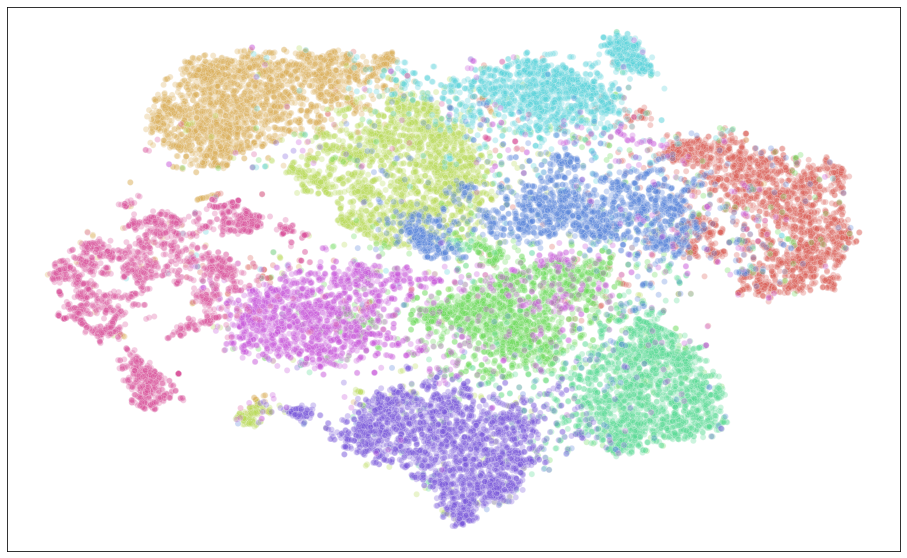

In [45]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
tsne_plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend=None,
    alpha=0.3
)

tsne_plot.set(xticklabels=[])  # remove the tick labels
tsne_plot.set(yticklabels=[])  # remove the tick labels
tsne_plot.set(xlabel=None)  # remove the axis label
tsne_plot.set(ylabel=None)  # remove the axis label
tsne_plot.tick_params(bottom=False,left=False)
fig = tsne_plot.get_figure()

fig.savefig('tsne_pretrain.svg',transparent=True)